In [1]:
import pandas as pd

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve

from sklearn.ensemble import RandomForestClassifier


In [182]:
df_raw = pd.read_csv('Jan_2019_ontime.csv')

In [183]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DAY_OF_MONTH           583985 non-null  int64  
 1   DAY_OF_WEEK            583985 non-null  int64  
 2   OP_UNIQUE_CARRIER      583985 non-null  object 
 3   OP_CARRIER_AIRLINE_ID  583985 non-null  int64  
 4   OP_CARRIER             583985 non-null  object 
 5   TAIL_NUM               581442 non-null  object 
 6   OP_CARRIER_FL_NUM      583985 non-null  int64  
 7   ORIGIN_AIRPORT_ID      583985 non-null  int64  
 8   ORIGIN_AIRPORT_SEQ_ID  583985 non-null  int64  
 9   ORIGIN                 583985 non-null  object 
 10  DEST_AIRPORT_ID        583985 non-null  int64  
 11  DEST_AIRPORT_SEQ_ID    583985 non-null  int64  
 12  DEST                   583985 non-null  object 
 13  DEP_TIME               567633 non-null  float64
 14  DEP_DEL15              567630 non-nu

In [184]:
df_raw.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [185]:
df_raw = df_raw[df_raw['DIVERTED'] == 0]
df_raw = df_raw[df_raw['CANCELLED'] == 0]

In [186]:
df = df_raw[['DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'DEP_TIME_BLK', 'ORIGIN', 'DEST', 'DISTANCE', 'ARR_DEL15']]

In [187]:
df.dropna()
df = df.reset_index(drop=True)

In [188]:
df = df.rename(columns = {'DAY_OF_WEEK' : 'ON_WEEKEND'})
df['ON_WEEKEND'] = (df['ON_WEEKEND'] > 5).astype(int)

In [189]:
carrier_df = df[['OP_UNIQUE_CARRIER','ARR_DEL15']].groupby('OP_UNIQUE_CARRIER').sum().sort_values(by='ARR_DEL15',ascending=False)
carrier_df['CARRIER_cat'] = pd.qcut(carrier_df['ARR_DEL15'], 17, labels = False)
carrier_df

,ARR_DEL15,CARRIER_cat
OP_UNIQUE_CARRIER,,
WN,16111.0,16
OO,14024.0,15
AA,13741.0,14
DL,9403.0,13
UA,9156.0,12
B6,6429.0,11
YX,5864.0,10
MQ,5844.0,9
9E,4013.0,8


In [190]:
data_carrier = carrier_df.loc[df['OP_UNIQUE_CARRIER']].reset_index()
df['CARRIER_cat'] = data_carrier['CARRIER_cat']

In [191]:
time_blk_df = df[['DEP_TIME_BLK','ARR_DEL15']].groupby('DEP_TIME_BLK').sum().sort_values(by='ARR_DEL15',ascending=False)
time_blk_df['TIME_cat'] = pd.qcut(time_blk_df['ARR_DEL15'], 19, labels = False)
time_blk_df

,ARR_DEL15,TIME_cat
DEP_TIME_BLK,,
1700-1759,8270.0,18
1800-1859,7978.0,17
1600-1659,7576.0,16
1400-1459,7290.0,15
1500-1559,7281.0,14
1900-1959,7219.0,13
1200-1259,6639.0,12
1300-1359,6398.0,11
1100-1159,6361.0,10


In [192]:
data_time = time_blk_df.loc[df['DEP_TIME_BLK']].reset_index()
df['DEP_TIME_cat'] = data_time['TIME_cat']

In [193]:
origin_df = df[['ORIGIN','ARR_DEL15']].groupby('ORIGIN').sum().sort_values(by='ARR_DEL15',ascending=False)
origin_df['ORIGIN_cat'] = pd.qcut(origin_df['ARR_DEL15'], 25, labels = False)
origin_df

,ARR_DEL15,ORIGIN_cat
ORIGIN,,
ORD,7655.0,24
DFW,4322.0,24
LGA,4075.0,24
ATL,4013.0,24
SFO,3562.0,24
...,...,...
BRW,2.0,0
ADK,1.0,0
CPR,1.0,0


In [194]:
data_origin = origin_df.loc[df['ORIGIN']].reset_index()
df['ORIGIN_cat'] = data_origin['ORIGIN_cat']

In [195]:
dest_df = df[['DEST','ARR_DEL15']].groupby('DEST').sum().sort_values(by='ARR_DEL15',ascending=False)
dest_df['DEST_cat'] = pd.qcut(dest_df['ARR_DEL15'], 25, labels = False)
dest_df

,ARR_DEL15,DEST_cat
DEST,,
ORD,6441.0,24
LGA,4836.0,24
DFW,4282.0,24
ATL,3931.0,24
SFO,3642.0,24
...,...,...
CPR,3.0,0
STC,2.0,0
PPG,2.0,0


In [196]:
data_dest = dest_df.loc[df['DEST']].reset_index()
df['DEST_cat'] = data_dest['DEST_cat']

In [197]:
final_df = df[['ON_WEEKEND', 'CARRIER_cat','DEP_TIME_cat', 'ORIGIN_cat', 'DEST_cat', 'DISTANCE', 'ARR_DEL15']]
final_df

,ON_WEEKEND,CARRIER_cat,DEP_TIME_cat,ORIGIN_cat,DEST_cat,DISTANCE,ARR_DEL15
0,0,8,4,12,24,300.0,0.0
1,0,8,15,23,22,596.0,0.0
2,0,8,12,24,22,229.0,0.0
3,0,8,14,14,24,223.0,0.0
4,0,8,13,24,8,579.0,0.0
...,...,...,...,...,...,...,...
565958,0,12,5,3,21,3801.0,0.0
565959,0,12,5,3,3,129.0,0.0
565960,0,12,6,3,5,129.0,0.0
565961,0,12,17,3,5,129.0,0.0


In [30]:
def feature_importance(columns, classifier):        
    features = list(zip(columns, classifier.feature_importances_))
    sorted_features = sorted(features, key = lambda x: x[1]*-1)
    
    keys = [value[0] for value in sorted_features]
    values = [value[1] for value in sorted_features]
    return pd.DataFrame(data={'feature': keys, 'value': values})

In [100]:
def get_roc_curve(df):
    df_X = final_df.drop('ARR_DEL15', axis=1)
    df_y = final_df[['ARR_DEL15']]

    X = df_X.values
    y = df_y.values

    y = LabelBinarizer().fit_transform(y)

    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)

    X = StandardScaler().fit_transform(X)
    X = MinMaxScaler().fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    
    model = RandomForestClassifier()
    model = model.fit(X_train, y_train)
    
    y_pred_test = model.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))
    
    print(classification_report(y_test, y_pred_test))
    
    return feature_importance(df_X.columns.to_list(), model), plot_roc_curve(model, X_test, y_test)

[[70136 22003]
 [19678 72480]]
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     92139
           1       0.77      0.79      0.78     92158

    accuracy                           0.77    184297
   macro avg       0.77      0.77      0.77    184297
weighted avg       0.77      0.77      0.77    184297



/home/tomaz/anaconda3/envs/clean/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


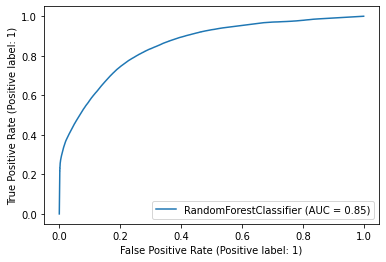

In [199]:
importance, plot = get_roc_curve(final_df)

In [200]:
importance

,feature,value
0,DISTANCE,0.291018
1,DEP_TIME_cat,0.239628
2,ON_WEEKEND,0.190071
3,CARRIER_cat,0.112618
4,ORIGIN_cat,0.084450
5,DEST_cat,0.082215


In [32]:
from graphdatascience import GraphDataScience

host = 'bolt://localhost:7687'
user = 'neo4j'
password = 'letmein'

gds = GraphDataScience(host, auth=(user,password))


In [33]:
print(gds.version())


2.0.3


In [34]:
df_raw

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583980,31,4,UA,19977,UA,N776UA,200,12016,1201602,GUM,...,HNL,749.0,0.0,0700-0759,1832.0,0.0,0.0,0.0,3801.0,NaN
583981,31,4,UA,19977,UA,N36280,174,12016,1201602,GUM,...,SPN,717.0,0.0,0700-0759,759.0,0.0,0.0,0.0,129.0,NaN
583982,31,4,UA,19977,UA,N36280,117,14955,1495503,SPN,...,GUM,857.0,0.0,0900-0959,933.0,0.0,0.0,0.0,129.0,NaN
583983,31,4,UA,19977,UA,N39726,105,14955,1495503,SPN,...,GUM,1820.0,0.0,1800-1859,1854.0,0.0,0.0,0.0,129.0,NaN


In [35]:
#import airports
airports = df_raw['ORIGIN'].unique().tolist()

gds.run_cypher("""
UNWIND $data AS airport_id
CREATE (:Airport {id: airport_id})
""", {'data': airports})


""


In [36]:
# import connections

connections = df_raw.groupby(['DEST', 'ORIGIN']).size().to_frame('count').reset_index()

gds.run_cypher("""
UNWIND $data AS row
MATCH (origin:Airport {id: row.ORIGIN})
MATCH (target:Airport {id: row.DEST})
MERGE (origin)-[c:CONNECTION]->(target)
SET c.count = row.count
""", {'data': connections.to_dict('records')})

""


In [37]:
G, res = gds.graph.project('airports','Airport', 'CONNECTION', relationshipProperties=['count'])

In [58]:
# Degree centrality

pr = gds.degree.stream(G, relationshipWeightProperty='count', orientation='UNDIRECTED')
pr['airport_id'] = [n.get('id') for n in gds.util.asNodes(pr['nodeId'].to_list())]
pr = pr[['airport_id', 'score']].set_index('airport_id')

dest_pr = pr.loc[df['DEST']].reset_index()
origin_pr = pr.loc[df['ORIGIN']].reset_index()

df['ORIGIN_d'] = origin_bc['score']
df['DEST_d'] = dest_bc['score']

In [99]:
#final_df = df[['ON_WEEKEND', 'CARRIER_cat','DEP_TIME_cat', 'DISTANCE', 'ARR_DEL15', 'ORIGIN_d', 'DEST_d']]
final_df = df[['ON_WEEKEND', 'CARRIER_cat','DEP_TIME_cat', 'DISTANCE', 'ARR_DEL15', 'DEST_d']]

[[70584 21555]
 [19468 72690]]
              precision    recall  f1-score   support

           0       0.78      0.77      0.77     92139
           1       0.77      0.79      0.78     92158

    accuracy                           0.78    184297
   macro avg       0.78      0.78      0.78    184297
weighted avg       0.78      0.78      0.78    184297



/home/tomaz/anaconda3/envs/clean/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


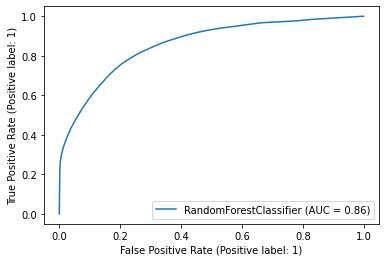

In [101]:
importance, plot = get_roc_curve(final_df)

In [102]:
importance

,feature,value
0,DISTANCE,0.283501
1,DEP_TIME_cat,0.265457
2,ON_WEEKEND,0.198504
3,DEST_d,0.143181
4,CARRIER_cat,0.109357


In [95]:
# betweenness centrality

pr = gds.betweenness.stream(G)
pr['airport_id'] = [n.get('id') for n in gds.util.asNodes(pr['nodeId'].to_list())]
pr = pr[['airport_id', 'score']].set_index('airport_id')

dest_pr = pr.loc[df['DEST']].reset_index()
origin_pr = pr.loc[df['ORIGIN']].reset_index()

df['ORIGIN_bc'] = origin_bc['score']
df['DEST_bc'] = dest_bc['score']

In [145]:
final_df = df[['ON_WEEKEND', 'CARRIER_cat','DEP_TIME_cat', 'DISTANCE', 'ARR_DEL15', 'DEST_bc']]

[[70631 21508]
 [19453 72705]]
              precision    recall  f1-score   support

           0       0.78      0.77      0.78     92139
           1       0.77      0.79      0.78     92158

    accuracy                           0.78    184297
   macro avg       0.78      0.78      0.78    184297
weighted avg       0.78      0.78      0.78    184297



/home/tomaz/anaconda3/envs/clean/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


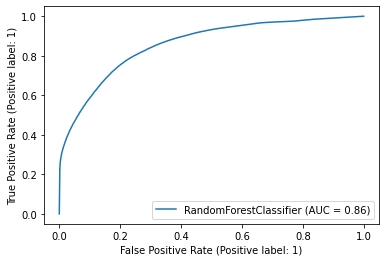

In [146]:
importance, plot = get_roc_curve(final_df)

In [147]:
importance

,feature,value
0,DISTANCE,0.282917
1,DEP_TIME_cat,0.264801
2,ON_WEEKEND,0.198412
3,DEST_bc,0.144578
4,CARRIER_cat,0.109292


In [149]:
# pagerank centrality

pr = gds.pageRank.stream(G, relationshipWeightProperty="count")
pr['airport_id'] = [n.get('id') for n in gds.util.asNodes(pr['nodeId'].to_list())]
pr = pr[['airport_id', 'score']].set_index('airport_id')

dest_pr = pr.loc[df['DEST']].reset_index()
origin_pr = pr.loc[df['ORIGIN']].reset_index()

df['ORIGIN_pr'] = origin_bc['score']
df['DEST_pr'] = dest_bc['score']

In [153]:
final_df = df[['ON_WEEKEND', 'CARRIER_cat','DEP_TIME_cat', 'DISTANCE', 'ARR_DEL15', 'DEST_pr']]

[[70645 21494]
 [19612 72546]]
              precision    recall  f1-score   support

           0       0.78      0.77      0.77     92139
           1       0.77      0.79      0.78     92158

    accuracy                           0.78    184297
   macro avg       0.78      0.78      0.78    184297
weighted avg       0.78      0.78      0.78    184297



/home/tomaz/anaconda3/envs/clean/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


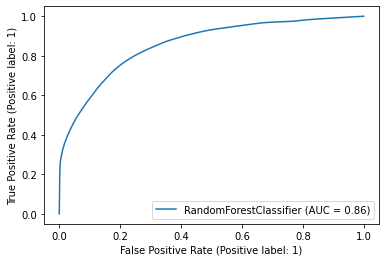

In [154]:
importance, plot = get_roc_curve(final_df)

In [155]:
importance

,feature,value
0,DISTANCE,0.282332
1,DEP_TIME_cat,0.266679
2,ON_WEEKEND,0.197892
3,DEST_pr,0.143883
4,CARRIER_cat,0.109214


In [107]:
# Louvain
pr = gds.louvain.stream(G, relationshipWeightProperty='count')
pr['airport_id'] = [n.get('id') for n in gds.util.asNodes(pr['nodeId'].to_list())]
pr = pr[['airport_id', 'communityId']].set_index('airport_id')

dest_louvain = pr.loc[df['DEST']].reset_index()
origin_louvain = pr.loc[df['ORIGIN']].reset_index()

df['ORIGIN_louvain'] = origin_louvain['communityId']
df['DEST_louvain'] = dest_louvain['communityId']

In [114]:
df['same_community'] = df.apply(lambda x: 1 if x['ORIGIN_louvain'] == x['DEST_louvain'] else 0, axis=1)

In [116]:
final_df = df[['ON_WEEKEND', 'CARRIER_cat','DEP_TIME_cat', 'DISTANCE', 'ARR_DEL15', 'DEST_d', 'same_community']]

[[70670 21469]
 [20014 72144]]
              precision    recall  f1-score   support

           0       0.78      0.77      0.77     92139
           1       0.77      0.78      0.78     92158

    accuracy                           0.77    184297
   macro avg       0.77      0.77      0.77    184297
weighted avg       0.77      0.77      0.77    184297



/home/tomaz/anaconda3/envs/clean/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


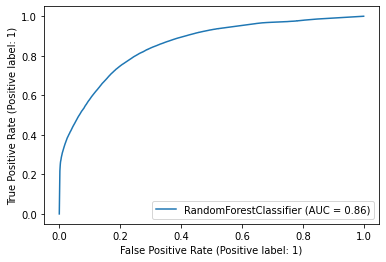

In [117]:
importance, plot = get_roc_curve(final_df)

In [118]:
importance

,feature,value
0,DEP_TIME_cat,0.278291
1,DISTANCE,0.258854
2,ON_WEEKEND,0.198228
3,DEST_d,0.138881
4,CARRIER_cat,0.111634
5,same_community,0.014111


In [134]:
# embeddings

In [62]:
res

nodeProjection            {'Airport': {'label': 'Airport', 'properties':...
relationshipProjection    {'CONNECTION': {'orientation': 'NATURAL', 'agg...
graphName                                                          airports
nodeCount                                                               346
relationshipCount                                                      5532
projectMillis                                                            32
Name: 0, dtype: object

In [156]:
airport_embeddings = gds.fastRP.stream(G, embeddingDimension=8, relationshipWeightProperty='count')

In [157]:
airport_embeddings['airport_id'] = [n.get('id') for n in gds.util.asNodes(airport_embeddings['nodeId'].to_list())]

In [158]:
airport_embeddings = airport_embeddings[['airport_id', 'embedding']].set_index('airport_id')

In [159]:
airport_embeddings

,embedding
airport_id,
GNV,"[0.3509531319141388, 0.11200349777936935, -0.1..."
MSP,"[0.4740193486213684, -0.2940526008605957, -0.4..."
DTW,"[0.5773559212684631, -0.1980077624320984, -0.4..."
TLH,"[0.4012877941131592, 0.03810671716928482, -0.3..."
ATL,"[0.48828572034835815, -0.1439044326543808, -0...."
...,...
OWB,"[0.1433384269475937, -0.6602402925491333, 0.07..."
OGS,"[-0.10459548234939575, -0.6810443997383118, -0..."
PPG,"[-0.16898754239082336, 0.6526230573654175, 0.5..."


In [160]:
dest_embedding = airport_embeddings.loc[df['DEST']].reset_index()
origin_embedding = airport_embeddings.loc[df['ORIGIN']].reset_index()


In [161]:
df['ORIGIN_emb'] = origin_embedding['embedding']
df['DEST_emb'] = dest_embedding['embedding']

In [162]:
final_df = df[['ON_WEEKEND', 'CARRIER_cat','DEP_TIME_cat', 'DEST_d', 'DISTANCE', 'ARR_DEL15', 'ORIGIN_emb', 'DEST_emb']]

In [163]:
final_df

,ON_WEEKEND,CARRIER_cat,DEP_TIME_cat,DEST_d,DISTANCE,ARR_DEL15,ORIGIN_emb,DEST_emb
0,0,8,4,13719.920359,300.0,0.0,"[0.3509531319141388, 0.11200349777936935, -0.1...","[0.48828572034835815, -0.1439044326543808, -0...."
1,0,8,15,427.651418,596.0,0.0,"[0.4740193486213684, -0.2940526008605957, -0.4...","[0.4428974688053131, -0.24343664944171906, -0...."
2,0,8,12,427.651418,229.0,0.0,"[0.5773559212684631, -0.1980077624320984, -0.4...","[0.4428974688053131, -0.24343664944171906, -0...."
3,0,8,14,13719.920359,223.0,0.0,"[0.4012877941131592, 0.03810671716928482, -0.3...","[0.48828572034835815, -0.1439044326543808, -0...."
4,0,8,13,0.000000,579.0,0.0,"[0.48828572034835815, -0.1439044326543808, -0....","[0.4804370701313019, -0.046937376260757446, -0..."
...,...,...,...,...,...,...,...,...
565958,0,12,5,2438.626399,3801.0,0.0,"[-0.22749248147010803, 0.01737743616104126, 0....","[0.08188365399837494, 0.35334354639053345, 0.3..."
565959,0,12,5,0.000000,129.0,0.0,"[-0.22749248147010803, 0.01737743616104126, 0....","[-0.11017882823944092, -0.011444123461842537, ..."
565960,0,12,6,688.000000,129.0,0.0,"[-0.11017882823944092, -0.011444123461842537, ...","[-0.22749248147010803, 0.01737743616104126, 0...."
565961,0,12,17,688.000000,129.0,0.0,"[-0.11017882823944092, -0.011444123461842537, ...","[-0.22749248147010803, 0.01737743616104126, 0...."


In [166]:
origin_df = pd.DataFrame(df['ORIGIN_emb'].tolist(), columns= [f'ORIGIN_emb_{i}' for i in range(0,8) ])
dest_df = pd.DataFrame(df['DEST_emb'].tolist(), columns= [f'DEST_emb_{i}' for i in range(0,8) ] )

In [167]:
final_df = pd.concat([final_df, origin_df], axis=1)
#

In [168]:
final_df = pd.concat([final_df, dest_df], axis=1)

In [169]:
final_df

,ON_WEEKEND,CARRIER_cat,DEP_TIME_cat,DEST_d,DISTANCE,ARR_DEL15,ORIGIN_emb,DEST_emb,ORIGIN_emb_0,ORIGIN_emb_1,...,ORIGIN_emb_6,ORIGIN_emb_7,DEST_emb_0,DEST_emb_1,DEST_emb_2,DEST_emb_3,DEST_emb_4,DEST_emb_5,DEST_emb_6,DEST_emb_7
0,0,8,4,13719.920359,300.0,0.0,"[0.3509531319141388, 0.11200349777936935, -0.1...","[0.48828572034835815, -0.1439044326543808, -0....",0.362123,0.430523,...,-0.488964,0.037566,0.488286,-0.143904,-0.461343,1.636181,-0.584869,0.141743,-0.420671,0.319940
1,0,8,15,427.651418,596.0,0.0,"[0.4740193486213684, -0.2940526008605957, -0.4...","[0.4428974688053131, -0.24343664944171906, -0....",0.296298,0.536606,...,-0.250948,0.291740,0.442897,-0.243437,-0.529193,1.674330,-0.628190,0.127777,-0.243146,0.200119
2,0,8,12,427.651418,229.0,0.0,"[0.5773559212684631, -0.1980077624320984, -0.4...","[0.4428974688053131, -0.24343664944171906, -0....",0.416600,0.613501,...,-0.404439,0.320881,0.442897,-0.243437,-0.529193,1.674330,-0.628190,0.127777,-0.243146,0.200119
3,0,8,14,13719.920359,223.0,0.0,"[0.4012877941131592, 0.03810671716928482, -0.3...","[0.48828572034835815, -0.1439044326543808, -0....",0.374707,0.454691,...,-0.528712,0.022374,0.488286,-0.143904,-0.461343,1.636181,-0.584869,0.141743,-0.420671,0.319940
4,0,8,13,0.000000,579.0,0.0,"[0.48828572034835815, -0.1439044326543808, -0....","[0.4804370701313019, -0.046937376260757446, -0...",0.374494,0.561838,...,-0.420671,0.319940,0.480437,-0.046937,-0.130251,1.698588,-0.155157,0.379529,-0.302744,0.166776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565958,0,12,5,2438.626399,3801.0,0.0,"[-0.22749248147010803, 0.01737743616104126, 0....","[0.08188365399837494, 0.35334354639053345, 0.3...",-0.149099,0.290574,...,0.406791,-0.060132,0.081884,0.353344,0.301195,1.208431,-0.152420,1.038565,0.424426,0.387755
565959,0,12,5,0.000000,129.0,0.0,"[-0.22749248147010803, 0.01737743616104126, 0....","[-0.11017882823944092, -0.011444123461842537, ...",-0.149099,0.290574,...,0.406791,-0.060132,-0.110179,-0.011444,0.362709,0.526530,-0.129648,0.577856,0.456652,-0.261288
565960,0,12,6,688.000000,129.0,0.0,"[-0.11017882823944092, -0.011444123461842537, ...","[-0.22749248147010803, 0.01737743616104126, 0....",-0.124284,0.243942,...,0.456652,-0.261288,-0.227492,0.017377,0.388235,0.739366,-0.344539,0.861421,0.406791,-0.060132
565961,0,12,17,688.000000,129.0,0.0,"[-0.11017882823944092, -0.011444123461842537, ...","[-0.22749248147010803, 0.01737743616104126, 0....",-0.124284,0.243942,...,0.456652,-0.261288,-0.227492,0.017377,0.388235,0.739366,-0.344539,0.861421,0.406791,-0.060132


In [170]:
df_X = final_df.drop(['ARR_DEL15', 'ORIGIN_emb', 'DEST_emb'], axis=1)
df_y = final_df[['ARR_DEL15']]

In [171]:
X = df_X.values
y = df_y.values

In [172]:
y = LabelBinarizer().fit_transform(y)

In [173]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [174]:
X = StandardScaler().fit_transform(X)
X = MinMaxScaler().fit_transform(X)

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


In [176]:
model = RandomForestClassifier()
model = model.fit(X_train, y_train)

In [177]:
y_pred_test = model.predict(X_test)

In [178]:
print(confusion_matrix(y_test, y_pred_test))


[[70210 21929]
 [20971 71187]]


In [179]:
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.77      0.76      0.77     92139
           1       0.76      0.77      0.77     92158

    accuracy                           0.77    184297
   macro avg       0.77      0.77      0.77    184297
weighted avg       0.77      0.77      0.77    184297



/home/tomaz/anaconda3/envs/clean/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


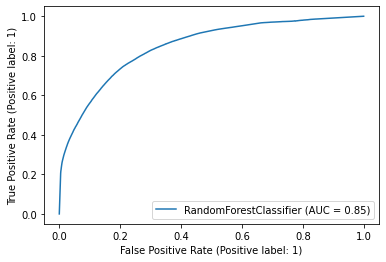

In [180]:
plot_roc_curve(model, X_test, y_test)
